# **Final Project**
# *FreshGuard Shelf-Life Predictor*

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load data
df = pd.read_csv('Datasets/FreshGuard_RAW_dirty.csv')

# Basic info
print(df.info())
print(df.describe())
print(df.head())

# Check data types
print(df.dtypes)
# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552 entries, 0 to 3551
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Produce_Type               3552 non-null   object 
 1   Harvest_Date               3552 non-null   object 
 2   Measurement_Date           3552 non-null   object 
 3   Initial_Brix_Level         3329 non-null   float64
 4   Initial_Weight             3313 non-null   float64
 5   Initial_Damage_Score       3158 non-null   float64
 6   Pretreatment               3362 non-null   object 
 7   Avg_Temp_C                 3201 non-null   float64
 8   Avg_Humidity_%             3329 non-null   float64
 9   Packaging                  3445 non-null   object 
 10  Age_at_Measurement         3552 non-null   int64  
 11  Remaining_Shelf_Life_Days  3552 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 333.1+ KB
None
       Initial_Brix_Level  Initial_Weigh

## Step 2: Feature Understanding
### features include:

>Produce_Type - Categorical (fruit/vegetable type)

>Harvest_Date - Temporal feature

>Measurement_Date - Temporal feature

>Initial_Brix_Level - Numerical (sugar content - 223 missing)

>Initial_Weight - Numerical (239 missing)

>Initial_Damage_Score - Numerical (394 missing - highest!)

>Pretreatment - Categorical (190 missing)

>Avg_Temp_C - Numerical (351 missing)

>Avg_Humidity_% - Numerical (223 missing)

>Packaging - Categorical (107 missing)

>Age_at_Measurement - Numerical (derived feature)

>Remaining_Shelf_Life_Days - Target variable (no missing)


## Step 3: Exploratory Data Analysis (EDA)

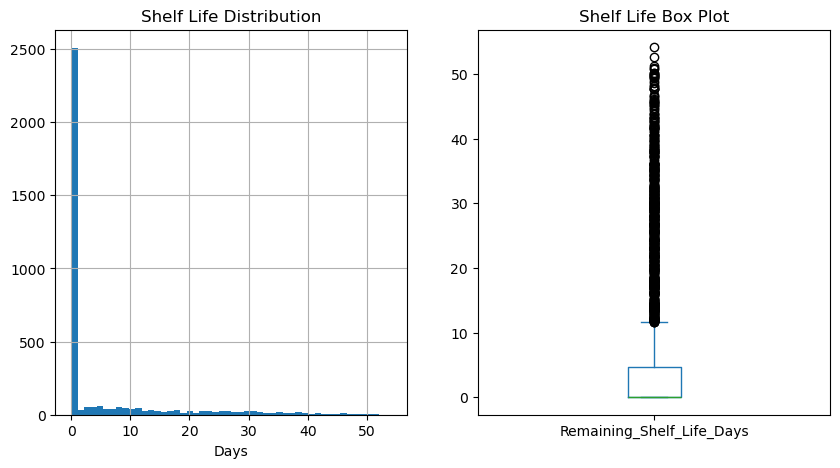

count    3552.000000
mean        5.294833
std        10.732328
min         0.000000
25%         0.000000
50%         0.000000
75%         4.644546
max        54.158676
Name: Remaining_Shelf_Life_Days, dtype: float64


In [20]:

# 1. Target variable distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['Remaining_Shelf_Life_Days'].hist(bins=50)
plt.title('Shelf Life Distribution')
plt.xlabel('Days')

plt.subplot(1, 2, 2)
df['Remaining_Shelf_Life_Days'].plot(kind='box')
plt.title('Shelf Life Box Plot')
plt.show()

# 2. Statistics
print(df['Remaining_Shelf_Life_Days'].describe())


> As we can see the shelf life of a large percentage of the target varable is zero so we have to find a way to treat these.For Which we will use the following methods

### Two-Stage Modeling:

### Stage 1 (Classification): Predict if product is expired (0) or not (>0)

>Using RandomForestClassifier or XGBoost with class_weight='balanced'

>Handles class imbalance well
### Stage 2 (Regression): For predicted non-expired items, predict actual shelf life

>Trains only on samples with Remaining_Shelf_Life_Days > 0

>Better predictions without zero-inflation


Target Variable Statistics:
  Total samples: 3552
  Zero values: 2448 (68.92%)
  Non-zero values: 1104 (31.08%)

Descriptive Statistics (All values):
count    3552.000000
mean        5.294833
std        10.732328
min         0.000000
25%         0.000000
50%         0.000000
75%         4.644546
max        54.158676
Name: Remaining_Shelf_Life_Days, dtype: float64

Descriptive Statistics (Non-zero only):
count    1104.000000
mean       17.035550
std        13.062504
min         0.063822
25%         5.818689
50%        13.450394
75%        26.824931
max        54.158676
Name: Remaining_Shelf_Life_Days, dtype: float64


/var/folders/gv/_2j5c9j56jd4by07zvrj4gx40000gn/T/ipykernel_76519/1276017516.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(box_data, labels=['With Zeros', 'Without Zeros'])


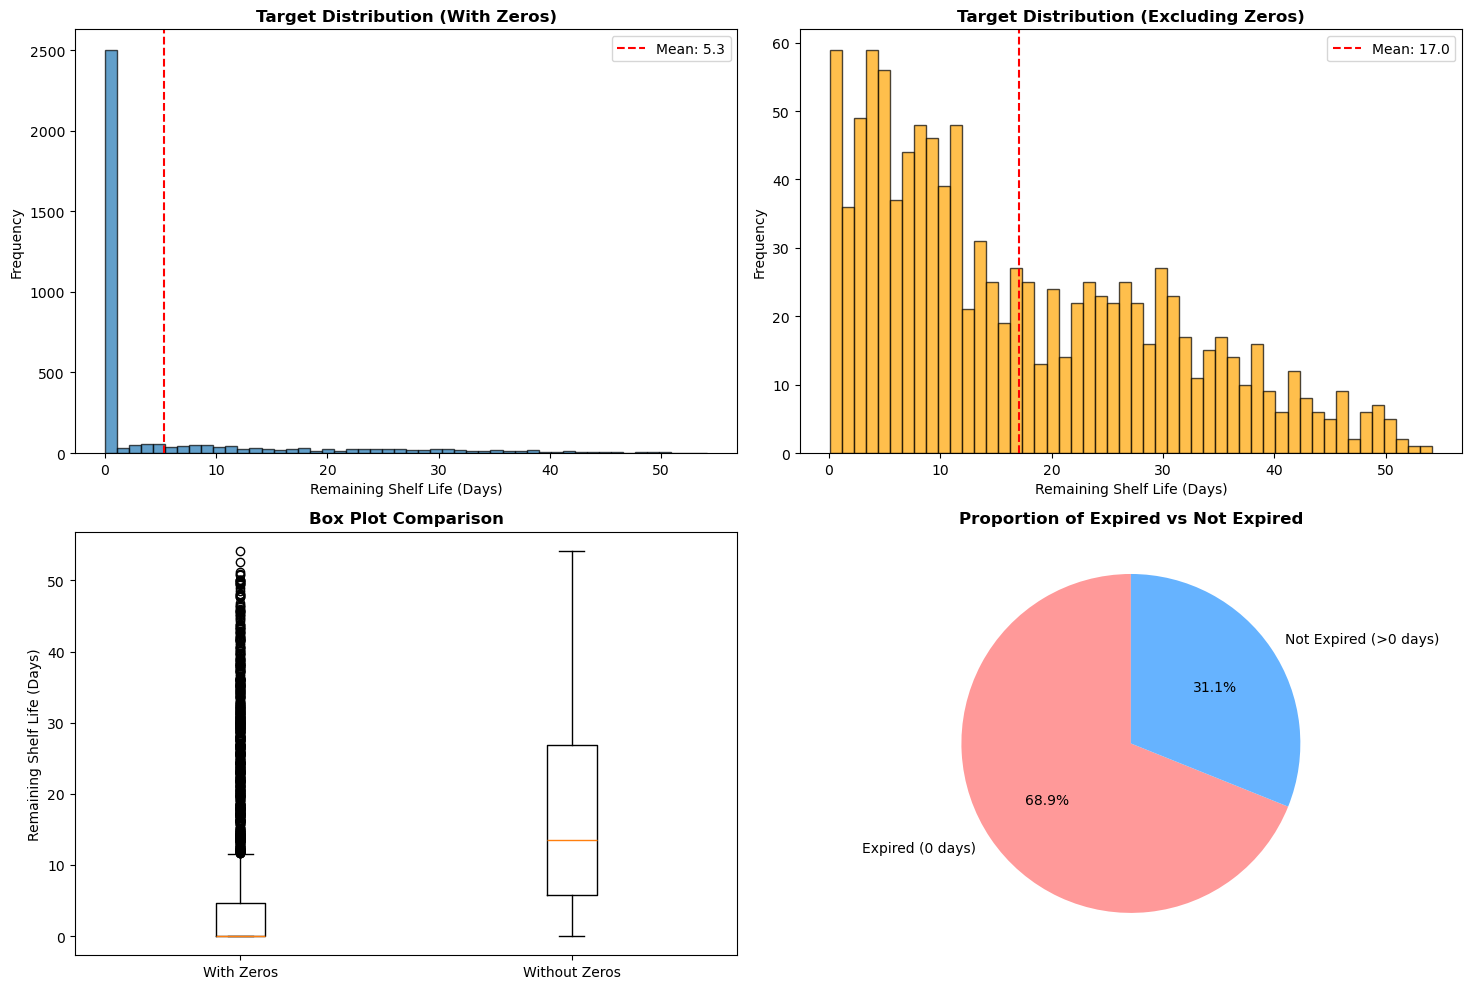


✓ Target analysis visualization saved as 'target_analysis.png'


In [21]:
zero_count = (df['Remaining_Shelf_Life_Days'] == 0).sum()
zero_percentage = (zero_count / len(df)) * 100
non_zero_count = (df['Remaining_Shelf_Life_Days'] > 0).sum()

print(f"\nTarget Variable Statistics:")
print(f"  Total samples: {len(df)}")
print(f"  Zero values: {zero_count} ({zero_percentage:.2f}%)")
print(f"  Non-zero values: {non_zero_count} ({100-zero_percentage:.2f}%)")
print(f"\nDescriptive Statistics (All values):")
print(df['Remaining_Shelf_Life_Days'].describe())
print(f"\nDescriptive Statistics (Non-zero only):")
print(df[df['Remaining_Shelf_Life_Days'] > 0]['Remaining_Shelf_Life_Days'].describe())

# Visualize target distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Full distribution with zeros
axes[0, 0].hist(df['Remaining_Shelf_Life_Days'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Target Distribution (With Zeros)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Remaining Shelf Life (Days)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['Remaining_Shelf_Life_Days'].mean(), color='red',
                   linestyle='--', label=f'Mean: {df["Remaining_Shelf_Life_Days"].mean():.1f}')
axes[0, 0].legend()

# Distribution without zeros
non_zero_data = df[df['Remaining_Shelf_Life_Days'] > 0]['Remaining_Shelf_Life_Days']
axes[0, 1].hist(non_zero_data, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Target Distribution (Excluding Zeros)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Remaining Shelf Life (Days)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(non_zero_data.mean(), color='red',
                   linestyle='--', label=f'Mean: {non_zero_data.mean():.1f}')
axes[0, 1].legend()

# Box plots comparison
box_data = [df['Remaining_Shelf_Life_Days'], non_zero_data]
axes[1, 0].boxplot(box_data, labels=['With Zeros', 'Without Zeros'])
axes[1, 0].set_title('Box Plot Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Remaining Shelf Life (Days)')

# Pie chart - Zero vs Non-zero
axes[1, 1].pie([zero_count, non_zero_count], labels=['Expired (0 days)', 'Not Expired (>0 days)'],
               autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
axes[1, 1].set_title('Proportion of Expired vs Not Expired', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('target_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Target analysis visualization saved as 'target_analysis.png'")

> For Outlier Detection: exclude zeros when calculating IQR bounds

STEP 3: OUTLIER DETECTION (ZERO-AWARE)

Outlier Detection Results:
  Zeros (kept as-is): 2448
  Outliers detected (non-zero): 0
  Valid range for non-zero: [-25.69, 58.33] days
  Outlier percentage (of non-zeros): 0.00%


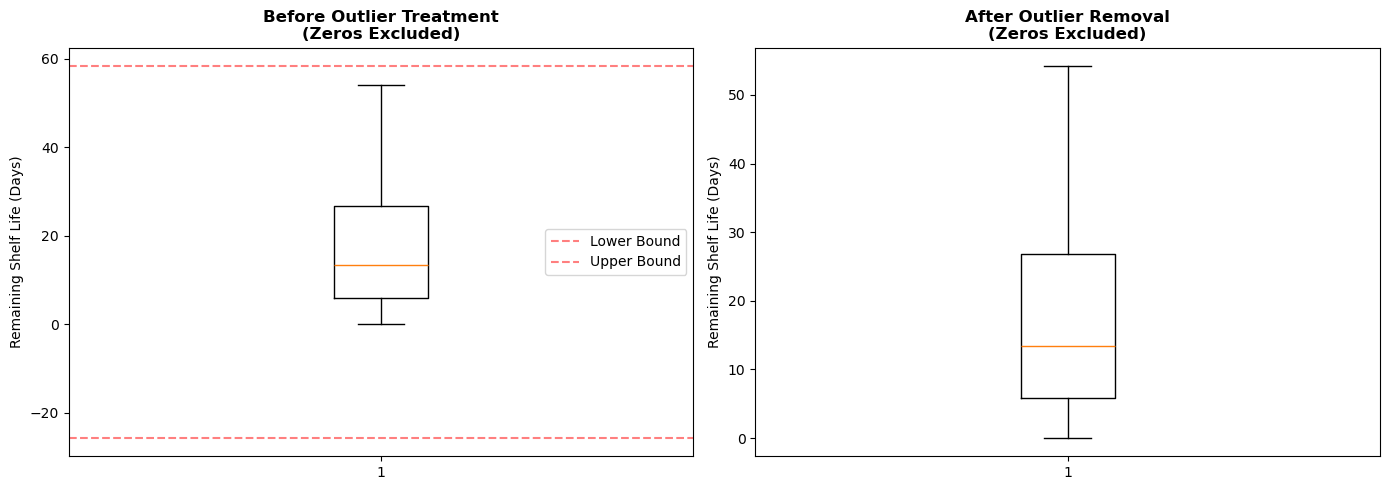


✓ Outliers removed. New dataset shape: (3552, 12)
✓ Outlier detection visualization saved as 'outlier_detection.png'


In [22]:
print("STEP 3: OUTLIER DETECTION (ZERO-AWARE)")
print("="*80)

def detect_outliers_excluding_zeros(data, column, multiplier=1.5):
    """Detect outliers using IQR method, treating zeros separately"""
    non_zero_data = data[data[column] > 0][column]

    Q1 = non_zero_data.quantile(0.25)
    Q3 = non_zero_data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Only flag non-zero values as outliers
    outliers_mask = ((data[column] > 0) &
                     ((data[column] < lower_bound) | (data[column] > upper_bound)))

    return outliers_mask, lower_bound, upper_bound

# Detect outliers in target
outliers_mask, lower, upper = detect_outliers_excluding_zeros(df, 'Remaining_Shelf_Life_Days')

print(f"\nOutlier Detection Results:")
print(f"  Zeros (kept as-is): {zero_count}")
print(f"  Outliers detected (non-zero): {outliers_mask.sum()}")
print(f"  Valid range for non-zero: [{lower:.2f}, {upper:.2f}] days")
print(f"  Outlier percentage (of non-zeros): {outliers_mask.sum()/non_zero_count*100:.2f}%")

# Visualize outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before outlier treatment
non_zero_before = df[df['Remaining_Shelf_Life_Days'] > 0]['Remaining_Shelf_Life_Days']
axes[0].boxplot(non_zero_before)
axes[0].set_title('Before Outlier Treatment\n(Zeros Excluded)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Remaining Shelf Life (Days)')
axes[0].axhline(lower, color='red', linestyle='--', alpha=0.5, label='Lower Bound')
axes[0].axhline(upper, color='red', linestyle='--', alpha=0.5, label='Upper Bound')
axes[0].legend()

# After outlier treatment (option: remove or cap)
# Option A: Remove outliers
df_clean = df[~outliers_mask].copy()
non_zero_after = df_clean[df_clean['Remaining_Shelf_Life_Days'] > 0]['Remaining_Shelf_Life_Days']

# Option B: Cap outliers (uncomment to use)
# df_clean = df.copy()
# df_clean.loc[outliers_mask & (df_clean['Remaining_Shelf_Life_Days'] < lower), 'Remaining_Shelf_Life_Days'] = lower
# df_clean.loc[outliers_mask & (df_clean['Remaining_Shelf_Life_Days'] > upper), 'Remaining_Shelf_Life_Days'] = upper

axes[1].boxplot(non_zero_after)
axes[1].set_title('After Outlier Removal\n(Zeros Excluded)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Remaining Shelf Life (Days)')

plt.tight_layout()
plt.savefig('outlier_detection.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Outliers removed. New dataset shape: {df_clean.shape}")
print("✓ Outlier detection visualization saved as 'outlier_detection.png'")

# Use cleaned dataset
df = df_clean.copy()


> As we can see there are no outliers in our data set once we exclude the zeros now coming to the features we will divide the date and time of harvest to seasons because the month and time is too granular to work with so by converting it to seasons we will get

| Season                    | Typical Climate    | Possible Shelf Life Effect           |
| ------------------------- | ------------------ | ------------------------------------ |
| Winter                    | Cold, low humidity | Slower decay (longer shelf life)     |
| Summer                    | Hot, humid         | Faster spoilage (shorter shelf life) |
| Autumn/Spring             | Moderate           | Balanced rate of spoilage            |


In [23]:
print("STEP 4: DATE FEATURE ENGINEERING")
print("="*80)

# Convert to datetime
df['Harvest_Date'] = pd.to_datetime(df['Harvest_Date'])
df['Measurement_Date'] = pd.to_datetime(df['Measurement_Date'])

# Extract features
df['Harvest_Month'] = df['Harvest_Date'].dt.month
df['Harvest_Day_of_Week'] = df['Harvest_Date'].dt.dayofweek
df['Harvest_Quarter'] = df['Harvest_Date'].dt.quarter
df['Measurement_Month'] = df['Measurement_Date'].dt.month
df['Days_Since_Harvest'] = (df['Measurement_Date'] - df['Harvest_Date']).dt.days

# Create season
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

df['Harvest_Season'] = df['Harvest_Month'].apply(get_season)

print("\nDate features created:")
print("  - Harvest_Month, Harvest_Day_of_Week, Harvest_Quarter, Harvest_Season")
print("  - Measurement_Month")
print("  - Days_Since_Harvest")

STEP 4: DATE FEATURE ENGINEERING

Date features created:
  - Harvest_Month, Harvest_Day_of_Week, Harvest_Quarter, Harvest_Season
  - Measurement_Month
  - Days_Since_Harvest


### Treat the missing values using the appropriate values like mode for packaging(porforated bag),median for numerical features and none for pretreatment

In [24]:
print("STEP 5: MISSING VALUE IMPUTATION")
print("="*80)

# Strategy for each feature
print("\nImputation strategy:")

# Categorical features with missing values
if df['Pretreatment'].isnull().any():
    df['Pretreatment'].fillna('None', inplace=True)
    print("  ✓ Pretreatment: Filled with 'None'")

if df['Packaging'].isnull().any():
    df['Packaging'].fillna(df['Packaging'].mode()[0], inplace=True)
    print(f"  ✓ Packaging: Filled with mode '{df['Packaging'].mode()[0]}'")

# Numerical features - impute by Produce_Type
numerical_cols_with_missing = ['Initial_Brix_Level', 'Initial_Weight',
                                'Initial_Damage_Score', 'Avg_Temp_C', 'Avg_Humidity_%']

for col in numerical_cols_with_missing:
    if col in df.columns and df[col].isnull().any():
        df[col] = df.groupby('Produce_Type')[col].transform(
            lambda x: x.fillna(x.median())
        )
        # If still missing (rare produce types), fill with overall median
        df[col].fillna(df[col].median(), inplace=True)
        print(f"  ✓ {col}: Filled with group median (by Produce_Type)")

print(f"\n✓ Missing values after imputation:\n{df.isnull().sum().sum()} total missing values")


STEP 5: MISSING VALUE IMPUTATION

Imputation strategy:
  ✓ Pretreatment: Filled with 'None'
  ✓ Packaging: Filled with mode 'perforated_bag'
  ✓ Initial_Brix_Level: Filled with group median (by Produce_Type)
  ✓ Initial_Weight: Filled with group median (by Produce_Type)
  ✓ Initial_Damage_Score: Filled with group median (by Produce_Type)
  ✓ Avg_Temp_C: Filled with group median (by Produce_Type)
  ✓ Avg_Humidity_%: Filled with group median (by Produce_Type)

✓ Missing values after imputation:
0 total missing values


/var/folders/gv/_2j5c9j56jd4by07zvrj4gx40000gn/T/ipykernel_76519/1179096553.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Pretreatment'].fillna('None', inplace=True)
/var/folders/gv/_2j5c9j56jd4by07zvrj4gx40000gn/T/ipykernel_76519/1179096553.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [25]:
print("STEP 6: FEATURE ENGINEERING")
print("="*80)

# Interaction features
df['Temp_Humidity_Interaction'] = df['Avg_Temp_C'] * df['Avg_Humidity_%']
df['Weight_Damage_Ratio'] = df['Initial_Weight'] / (df['Initial_Damage_Score'] + 1)
df['Brix_Weight_Ratio'] = df['Initial_Brix_Level'] / (df['Initial_Weight'] + 1)

# Polynomial features
df['Temp_Squared'] = df['Avg_Temp_C'] ** 2
df['Humidity_Squared'] = df['Avg_Humidity_%'] ** 2
df['Damage_Squared'] = df['Initial_Damage_Score'] ** 2

# Quality score
df['Quality_Score'] = (
    (df['Initial_Brix_Level'] / df['Initial_Brix_Level'].max()) * 0.3 +
    (1 - df['Initial_Damage_Score'] / df['Initial_Damage_Score'].max()) * 0.4 +
    (df['Initial_Weight'] / df['Initial_Weight'].max()) * 0.3
)

# Storage condition score
df['Storage_Stress_Score'] = (
    (df['Avg_Temp_C'] / df['Avg_Temp_C'].max()) * 0.5 +
    (df['Avg_Humidity_%'] / 100) * 0.5
)

print("\nEngineered features:")
print("  ✓ Interaction features: Temp_Humidity_Interaction, Weight_Damage_Ratio, Brix_Weight_Ratio")
print("  ✓ Polynomial features: Temp_Squared, Humidity_Squared, Damage_Squared")
print("  ✓ Composite scores: Quality_Score, Storage_Stress_Score")

STEP 6: FEATURE ENGINEERING

Engineered features:
  ✓ Interaction features: Temp_Humidity_Interaction, Weight_Damage_Ratio, Brix_Weight_Ratio
  ✓ Polynomial features: Temp_Squared, Humidity_Squared, Damage_Squared
  ✓ Composite scores: Quality_Score, Storage_Stress_Score


### Combined temperature and humidity — since both together influence spoilage rates.

> High temp + high humidity = faster spoilage.

> Low temp + low humidity = slower spoilage.

### Measured how much healthy mass is available relative to the damage.

> A higher value means a heavier item with less damage (better condition).

> The +1 avoids division by zero.

### Brix level = sugar content (used in fruits, juices, etc.)

>This ratio tells how concentrated the sugar is per gram of weight — a proxy for sweetness density or ripeness quality.

### Sometimes, effects aren’t linear,

> Small temperature increases may not matter,

> But after a threshold, spoilage skyrockets.

### Higher Quality_Score → better overall product condition.

| Component              | Meaning                           | Weight |
| ---------------------- | --------------------------------- | ------ |
| `Initial_Brix_Level`   | Sweetness (higher = better)       | 30%    |
| `Initial_Damage_Score` | Physical defects (lower = better) | 40%    |
| `Initial_Weight`       | Size/freshness (higher = better)  | 30%    |

### Strorage stress score

> Combines temperature and humidity equally (0.5 each).

> Both are normalized (scaled 0–1).

> Higher score = harsher storage conditions.

### Conclusion:

> Storage_Stress_Score → environmental risk

> Quality_Score → product’s intrinsic health

### We will do categorical encoding for the non_numeric data

> Low cardinality (few categories) → use One-Hot Encoding

> High cardinality (many unique values) → use Target Encoding or Label Encoding

In [26]:
from sklearn.preprocessing import LabelEncoder
print("STEP 7: CATEGORICAL ENCODING")
print("="*80)

# Check cardinality
print("\nCategorical feature cardinality:")
categorical_cols = ['Produce_Type', 'Pretreatment', 'Packaging']
for col in categorical_cols:
    if col in df.columns:
        print(f"  {col}: {df[col].nunique()} unique values")

# One-hot encode Pretreatment and Packaging (likely low cardinality)
df_encoded = pd.get_dummies(df, columns=['Pretreatment', 'Packaging'],
                             prefix=['Pretreatment', 'Packaging'],
                             drop_first=True)

# Target encoding for Produce_Type (handles high cardinality well)
produce_target_mean = df.groupby('Produce_Type')['Remaining_Shelf_Life_Days'].mean()
df_encoded['Produce_Type_Target_Enc'] = df_encoded['Produce_Type'].map(produce_target_mean)

# Also keep label encoded version
le_produce = LabelEncoder()
df_encoded['Produce_Type_Label'] = le_produce.fit_transform(df_encoded['Produce_Type'])

print("\n✓ Encoding complete:")
print(f"  - Produce_Type: Target encoded and Label encoded")
print(f"  - Pretreatment & Packaging: One-hot encoded")
print(f"  - New shape: {df_encoded.shape}")

# Drop original categorical columns and dates
columns_to_drop = ['Produce_Type', 'Harvest_Date', 'Measurement_Date']
df_encoded = df_encoded.drop(columns=columns_to_drop, errors='ignore')

STEP 7: CATEGORICAL ENCODING

Categorical feature cardinality:
  Produce_Type: 15 unique values
  Pretreatment: 5 unique values
  Packaging: 4 unique values

✓ Encoding complete:
  - Produce_Type: Target encoded and Label encoded
  - Pretreatment & Packaging: One-hot encoded
  - New shape: (3552, 33)


In [27]:
print("STEP 8: TWO-STAGE MODELING PREPARATION")
print("="*80)

# Create binary target (Stage 1: Expired vs Not Expired)
df_encoded['Is_Expired'] = (df_encoded['Remaining_Shelf_Life_Days'] == 0).astype(int)

print(f"\nBinary Classification Target:")
print(df_encoded['Is_Expired'].value_counts())
print(f"\nClass distribution:")
print(df_encoded['Is_Expired'].value_counts(normalize=True))

STEP 8: TWO-STAGE MODELING PREPARATION

Binary Classification Target:
Is_Expired
1    2448
0    1104
Name: count, dtype: int64

Class distribution:
Is_Expired
1    0.689189
0    0.310811
Name: proportion, dtype: float64


### Now we will do the train test split using two target variable as discussed before

In [28]:
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42
print("STEP 9: TRAIN-TEST SPLIT (STRATIFIED)")
print("="*80)

# Separate features and targets
X = df_encoded.drop(['Remaining_Shelf_Life_Days', 'Is_Expired'], axis=1)
y_regression = df_encoded['Remaining_Shelf_Life_Days']
y_classification = df_encoded['Is_Expired']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Features: {X.columns.tolist()}")

# Stratified split based on binary target
X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split(
    X, y_classification, y_regression,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_classification
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTrain set - Expired: {y_train_class.sum()} ({y_train_class.mean()*100:.2f}%)")
print(f"Test set - Expired: {y_test_class.sum()} ({y_test_class.mean()*100:.2f}%)")

STEP 9: TRAIN-TEST SPLIT (STRATIFIED)

Feature matrix shape: (3552, 29)
Features: ['Initial_Brix_Level', 'Initial_Weight', 'Initial_Damage_Score', 'Avg_Temp_C', 'Avg_Humidity_%', 'Age_at_Measurement', 'Harvest_Month', 'Harvest_Day_of_Week', 'Harvest_Quarter', 'Measurement_Month', 'Days_Since_Harvest', 'Harvest_Season', 'Temp_Humidity_Interaction', 'Weight_Damage_Ratio', 'Brix_Weight_Ratio', 'Temp_Squared', 'Humidity_Squared', 'Damage_Squared', 'Quality_Score', 'Storage_Stress_Score', 'Pretreatment_none', 'Pretreatment_pre-cooled', 'Pretreatment_washed', 'Pretreatment_waxed', 'Packaging_loose', 'Packaging_perforated_bag', 'Packaging_sealed_punnet', 'Produce_Type_Target_Enc', 'Produce_Type_Label']

Train set shape: (2841, 29)
Test set shape: (711, 29)

Train set - Expired: 1958 (68.92%)
Test set - Expired: 490 (68.92%)


In [29]:
from sklearn.preprocessing import StandardScaler
print("STEP 10: FEATURE SCALING")
print("="*80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Features scaled using StandardScaler")


STEP 10: FEATURE SCALING
✓ Features scaled using StandardScaler


In [30]:
df_encoded.to_csv('fresh_guard_preprocessed.csv', index=False)

STEP 11: FEATURE SELECTION

Top 20 Most Important Features:
                      feature  importance
27    Produce_Type_Target_Enc    0.487555
5          Age_at_Measurement    0.417986
10         Days_Since_Harvest    0.035908
28         Produce_Type_Label    0.020542
0          Initial_Brix_Level    0.014417
14          Brix_Weight_Ratio    0.006343
15               Temp_Squared    0.002212
3                  Avg_Temp_C    0.002000
12  Temp_Humidity_Interaction    0.001801
1              Initial_Weight    0.001110
18              Quality_Score    0.001098
19       Storage_Stress_Score    0.001012
13        Weight_Damage_Ratio    0.000978
4              Avg_Humidity_%    0.000906
16           Humidity_Squared    0.000898
17             Damage_Squared    0.000757
24            Packaging_loose    0.000734
2        Initial_Damage_Score    0.000710
7         Harvest_Day_of_Week    0.000686
21    Pretreatment_pre-cooled    0.000565


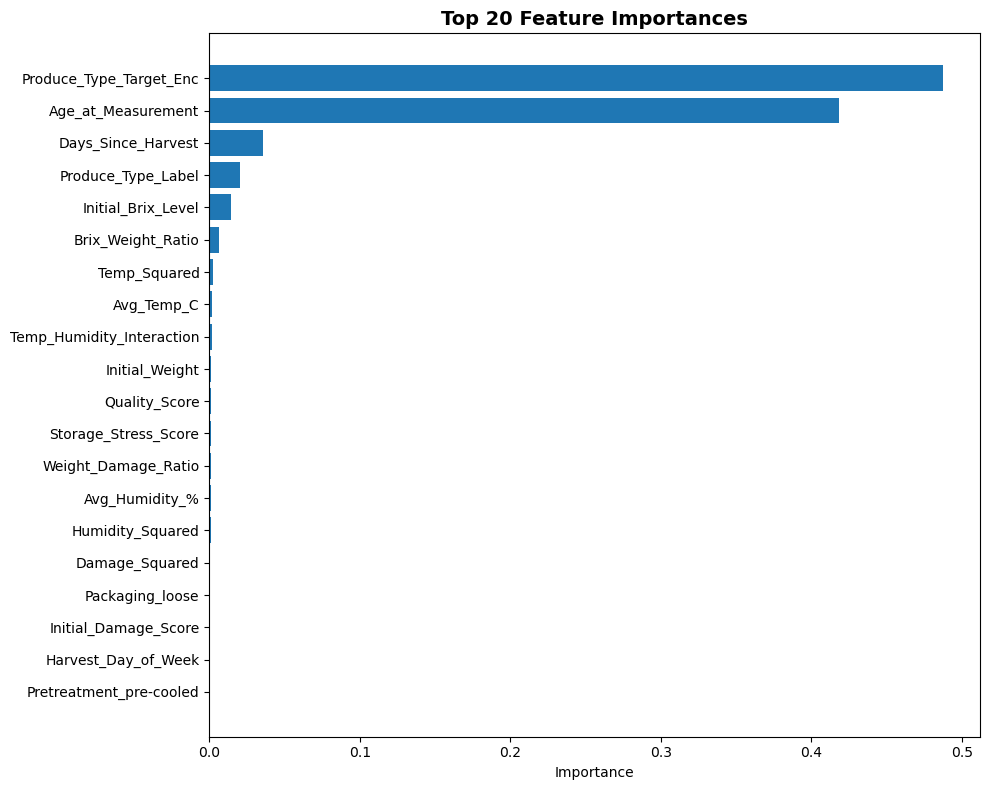


✓ Feature importance visualization saved as 'feature_importance.png'

✓ Using top 29 features for modeling


In [18]:
from sklearn.ensemble import RandomForestRegressor
print("STEP 11: FEATURE SELECTION")
print("="*80)

# Use Random Forest for feature importance
rf_temp = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_temp.fit(X_train_scaled, y_train_reg)

feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance visualization saved as 'feature_importance.png'")

# Select top features (or use all)
# Option: Use top K features
top_k = min(30, len(feature_importance))  # Use top 30 or all if less
selected_features = feature_importance.head(top_k)['feature'].tolist()

X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

print(f"\n✓ Using top {len(selected_features)} features for modeling")

> We used the random forest to find the feature importance of all the features and decided to use all the features

### Now we will use the classification for the zero target values(Expired-Not_expired) and then perform the regression for the non-zero data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
XGBOOST_AVAILABLE = True
from xgboost import XGBClassifier
print("STEP 12: STAGE 1 - BINARY CLASSIFICATION MODELING")
print("="*80)

print("\nTraining classification models...")

# Try multiple classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        n_jobs=-1
    )
}

if XGBOOST_AVAILABLE:
    scale_pos_weight = (y_train_class == 0).sum() / (y_train_class == 1).sum()
    classifiers['XGBoost'] = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

classification_results = {}

for name, clf in classifiers.items():
    print(f"\n--- {name} Classifier ---")
    clf.fit(X_train_selected, y_train_class)

    # Predictions
    y_pred_train = clf.predict(X_train_selected)
    y_pred_test = clf.predict(X_test_selected)
    y_pred_proba = clf.predict_proba(X_test_selected)[:, 1]

    # Metrics
    train_acc = accuracy_score(y_train_class, y_pred_train)
    test_acc = accuracy_score(y_test_class, y_pred_test)
    roc_auc = roc_auc_score(y_test_class, y_pred_proba)

    classification_results[name] = {
        'model': clf,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'roc_auc': roc_auc,
        'predictions': y_pred_test,
        'probabilities': y_pred_proba
    }

    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test_class, y_pred_test,
                                target_names=['Not Expired', 'Expired']))
    print(f"\nConfusion Matrix:")
    print(confusion_matrix(y_test_class, y_pred_test))

# Select best classifier
best_clf_name = max(classification_results.items(),
                    key=lambda x: x[1]['roc_auc'])[0]
best_classifier = classification_results[best_clf_name]['model']
y_pred_class_best = classification_results[best_clf_name]['predictions']

print(f"\n✓ Best Classifier: {best_clf_name} (ROC-AUC: {classification_results[best_clf_name]['roc_auc']:.4f})")

STEP 12: STAGE 1 - BINARY CLASSIFICATION MODELING

Training classification models...

--- Random Forest Classifier ---
Train Accuracy: 0.9923
Test Accuracy: 0.9775
ROC-AUC: 0.9965

Classification Report:
              precision    recall  f1-score   support

 Not Expired       0.97      0.96      0.96       221
     Expired       0.98      0.99      0.98       490

    accuracy                           0.98       711
   macro avg       0.97      0.97      0.97       711
weighted avg       0.98      0.98      0.98       711


Confusion Matrix:
[[212   9]
 [  7 483]]

--- XGBoost Classifier ---
Train Accuracy: 0.9982
Test Accuracy: 0.9831
ROC-AUC: 0.9982

Classification Report:
              precision    recall  f1-score   support

 Not Expired       0.98      0.97      0.97       221
     Expired       0.99      0.99      0.99       490

    accuracy                           0.98       711
   macro avg       0.98      0.98      0.98       711
weighted avg       0.98      0.98      0.9

> We found the XGBoost to be the best model(ROC-AUC = 0.9982) due it being improving every iteration meanwhile random forest also gave good result of (0.9965)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(" PART-13: STAGE 2: REGRESSION MODEL (NON-EXPIRED ONLY)")
print("="*80)

# Filter to non-zero shelf life for training
non_zero_mask_train = y_train_reg > 0
non_zero_mask_test = y_test_reg > 0

X_train_non_zero = X_train_selected[non_zero_mask_train]
y_train_non_zero = y_train_reg[non_zero_mask_train]

X_test_non_zero = X_test_selected[non_zero_mask_test]
y_test_non_zero = y_test_reg[non_zero_mask_test]

print(f"\nRegression training set size: {len(X_train_non_zero)}")
print(f"Regression test set size: {len(X_test_non_zero)}")

# Train regression models
regressors = {
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        random_state=RANDOM_STATE
    )
}

if XGBOOST_AVAILABLE:
    regressors['XGBoost'] = XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

regression_results = {}

for name, reg in regressors.items():
    print(f"\n--- {name} Regressor ---")
    reg.fit(X_train_non_zero, y_train_non_zero)

    # Predictions
    y_pred_train = reg.predict(X_train_non_zero)
    y_pred_test = reg.predict(X_test_non_zero)

    # Metrics
    train_mae = mean_absolute_error(y_train_non_zero, y_pred_train)
    test_mae = mean_absolute_error(y_test_non_zero, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train_non_zero, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test_non_zero, y_pred_test))
    train_r2 = r2_score(y_train_non_zero, y_pred_train)
    test_r2 = r2_score(y_test_non_zero, y_pred_test)

    regression_results[name] = {
        'model': reg,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'predictions': y_pred_test
    }

    print(f"Train MAE: {train_mae:.2f} days")
    print(f"Test MAE: {test_mae:.2f} days")
    print(f"Train RMSE: {train_rmse:.2f} days")
    print(f"Test RMSE: {test_rmse:.2f} days")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")

# Select best regressor
best_reg_name = max(regression_results.items(),
                    key=lambda x: x[1]['test_r2'])[0]
best_regressor = regression_results[best_reg_name]['model']

print(f"\n✓ Best Regressor: {best_reg_name} (Test R²: {regression_results[best_reg_name]['test_r2']:.4f})")

 PART-13: STAGE 2: REGRESSION MODEL (NON-EXPIRED ONLY)

Regression training set size: 883
Regression test set size: 221

--- Random Forest Regressor ---
Train MAE: 0.77 days
Test MAE: 1.96 days
Train RMSE: 1.01 days
Test RMSE: 2.44 days
Train R²: 0.9941
Test R²: 0.9617

--- Gradient Boosting Regressor ---
Train MAE: 0.45 days
Test MAE: 1.69 days
Train RMSE: 0.58 days
Test RMSE: 2.08 days
Train R²: 0.9981
Test R²: 0.9721

--- XGBoost Regressor ---
Train MAE: 0.26 days
Test MAE: 1.71 days
Train RMSE: 0.36 days
Test RMSE: 2.17 days
Train R²: 0.9993
Test R²: 0.9696

✓ Best Regressor: Gradient Boosting (Test R²: 0.9721)


> The best Regressor for non-zero data came out to be  the Classic Gradient Boosting

### Now we will combine the two models together to get the predictions and find the report

In [26]:
print("STEP-14: COMBINED TWO-STAGE MODEL PERFORMANCE")
print("="*80)

# Create final predictions
final_predictions = np.zeros(len(y_test_reg))

# Use classification predictions to decide
predicted_not_expired = y_pred_class_best == 0

# For items predicted as not expired, use regression model
if predicted_not_expired.sum() > 0:
    regression_predictions = best_regressor.predict(X_test_selected[predicted_not_expired])
    # Ensure non-negative predictions
    regression_predictions = np.maximum(regression_predictions, 0)
    final_predictions[predicted_not_expired] = regression_predictions

# Calculate overall metrics
overall_mae = mean_absolute_error(y_test_reg, final_predictions)
overall_rmse = np.sqrt(mean_squared_error(y_test_reg, final_predictions))
overall_r2 = r2_score(y_test_reg, final_predictions)

print(f"\nCombined Model Performance:")
print(f"  Overall MAE: {overall_mae:.2f} days")
print(f"  Overall RMSE: {overall_rmse:.2f} days")
print(f"  Overall R²: {overall_r2:.4f}")

# Breakdown by actual class
expired_mask = y_test_reg == 0
not_expired_mask = y_test_reg > 0

if expired_mask.sum() > 0:
    expired_mae = mean_absolute_error(y_test_reg[expired_mask], final_predictions[expired_mask])
    print(f"\n  For Actually Expired Items (n={expired_mask.sum()}):")
    print(f"    MAE: {expired_mae:.2f} days")

if not_expired_mask.sum() > 0:
    not_expired_mae = mean_absolute_error(y_test_reg[not_expired_mask], final_predictions[not_expired_mask])
    not_expired_r2 = r2_score(y_test_reg[not_expired_mask], final_predictions[not_expired_mask])
    print(f"\n  For Actually Non-Expired Items (n={not_expired_mask.sum()}):")
    print(f"    MAE: {not_expired_mae:.2f} days")
    print(f"    R²: {not_expired_r2:.4f}")


STEP-14: COMBINED TWO-STAGE MODEL PERFORMANCE

Combined Model Performance:
  Overall MAE: 0.53 days
  Overall RMSE: 1.17 days
  Overall R²: 0.9874

  For Actually Expired Items (n=490):
    MAE: 0.02 days

  For Actually Non-Expired Items (n=221):
    MAE: 1.67 days
    R²: 0.9724


> Our model came out to be pretty decent with less than 1.5 days as the avg error in predictions 

### Now we will visualize the data 

STEP 15: PREDICTION VISUALIZATIONS


C:\Users\Devil\AppData\Local\Temp\ipykernel_16312\1929526077.py:100: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax8.boxplot([expired_errors, not_expired_errors],


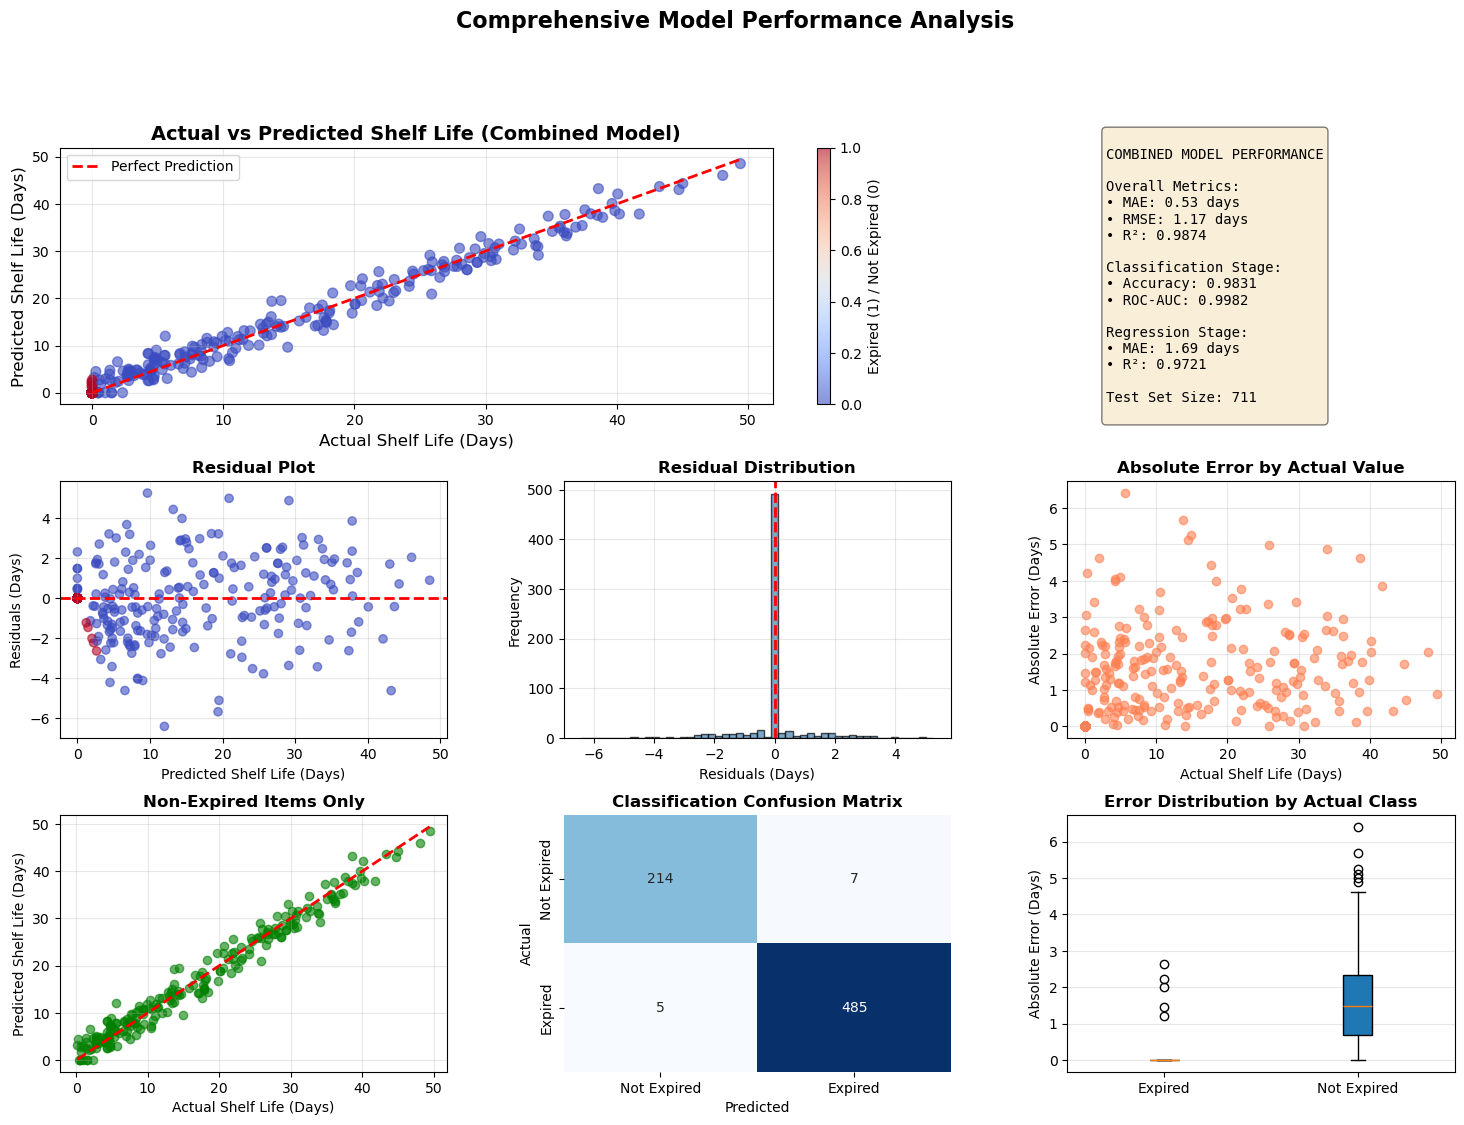


✓ Comprehensive visualization saved as 'model_performance_complete.png'


In [ ]:
print("STEP 15: PREDICTION VISUALIZATIONS")
print("="*80)

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Actual vs Predicted (All data)
ax1 = fig.add_subplot(gs[0, :2])
scatter = ax1.scatter(y_test_reg, final_predictions, alpha=0.6, c=y_test_class, cmap='coolwarm', s=50)
ax1.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Shelf Life (Days)', fontsize=12)
ax1.set_ylabel('Predicted Shelf Life (Days)', fontsize=12)
ax1.set_title('Actual vs Predicted Shelf Life (Combined Model)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Expired (1) / Not Expired (0)')

# 2. Model Performance Summary
ax2 = fig.add_subplot(gs[0, 2])
ax2.axis('off')
summary_text = f"""
COMBINED MODEL PERFORMANCE

Overall Metrics:
• MAE: {overall_mae:.2f} days
• RMSE: {overall_rmse:.2f} days
• R²: {overall_r2:.4f}

Classification Stage:
• Accuracy: {classification_results[best_clf_name]['test_accuracy']:.4f}
• ROC-AUC: {classification_results[best_clf_name]['roc_auc']:.4f}

Regression Stage:
• MAE: {regression_results[best_reg_name]['test_mae']:.2f} days
• R²: {regression_results[best_reg_name]['test_r2']:.4f}

Test Set Size: {len(y_test_reg)}
"""
ax2.text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Residual Plot
ax3 = fig.add_subplot(gs[1, 0])
residuals = y_test_reg - final_predictions
ax3.scatter(final_predictions, residuals, alpha=0.6, c=y_test_class, cmap='coolwarm')
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Predicted Shelf Life (Days)', fontsize=10)
ax3.set_ylabel('Residuals (Days)', fontsize=10)
ax3.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Residual Distribution
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax4.axvline(x=0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Residuals (Days)', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
ax4.set_title('Residual Distribution', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. Error by Actual Value
ax5 = fig.add_subplot(gs[1, 2])
abs_errors = np.abs(residuals)
ax5.scatter(y_test_reg, abs_errors, alpha=0.6, color='coral')
ax5.set_xlabel('Actual Shelf Life (Days)', fontsize=10)
ax5.set_ylabel('Absolute Error (Days)', fontsize=10)
ax5.set_title('Absolute Error by Actual Value', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# 6. Prediction vs Actual for Non-Expired Only
ax6 = fig.add_subplot(gs[2, 0])
mask_non_zero = y_test_reg > 0
ax6.scatter(y_test_reg[mask_non_zero], final_predictions[mask_non_zero], alpha=0.6, color='green')
ax6.plot([y_test_reg[mask_non_zero].min(), y_test_reg[mask_non_zero].max()],
         [y_test_reg[mask_non_zero].min(), y_test_reg[mask_non_zero].max()],
         'r--', lw=2)
ax6.set_xlabel('Actual Shelf Life (Days)', fontsize=10)
ax6.set_ylabel('Predicted Shelf Life (Days)', fontsize=10)
ax6.set_title('Non-Expired Items Only', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

# 7. Confusion Matrix for Classification Stage
ax7 = fig.add_subplot(gs[2, 1])
cm = confusion_matrix(y_test_class, y_pred_class_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax7, cbar=False,
            xticklabels=['Not Expired', 'Expired'],
            yticklabels=['Not Expired', 'Expired'])
ax7.set_xlabel('Predicted', fontsize=10)
ax7.set_ylabel('Actual', fontsize=10)
ax7.set_title('Classification Confusion Matrix', fontsize=12, fontweight='bold')

# 8. Error Distribution by Class
ax8 = fig.add_subplot(gs[2, 2])
expired_errors = abs_errors[y_test_reg == 0]
not_expired_errors = abs_errors[y_test_reg > 0]
ax8.boxplot([expired_errors, not_expired_errors],
            labels=['Expired', 'Not Expired'],
            patch_artist=True)
ax8.set_ylabel('Absolute Error (Days)', fontsize=10)
ax8.set_title('Error Distribution by Actual Class', fontsize=12, fontweight='bold')
ax8.grid(True, alpha=0.3, axis='y')

plt.suptitle('Comprehensive Model Performance Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('model_performance_complete.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comprehensive visualization saved as 'model_performance_complete.png'")

> As we can see the model is extremely precise(May be due to the use of a synthetic dataset) but the process are same for an actual dataset too

STEP 16: FEATURE IMPORTANCE ANALYSIS


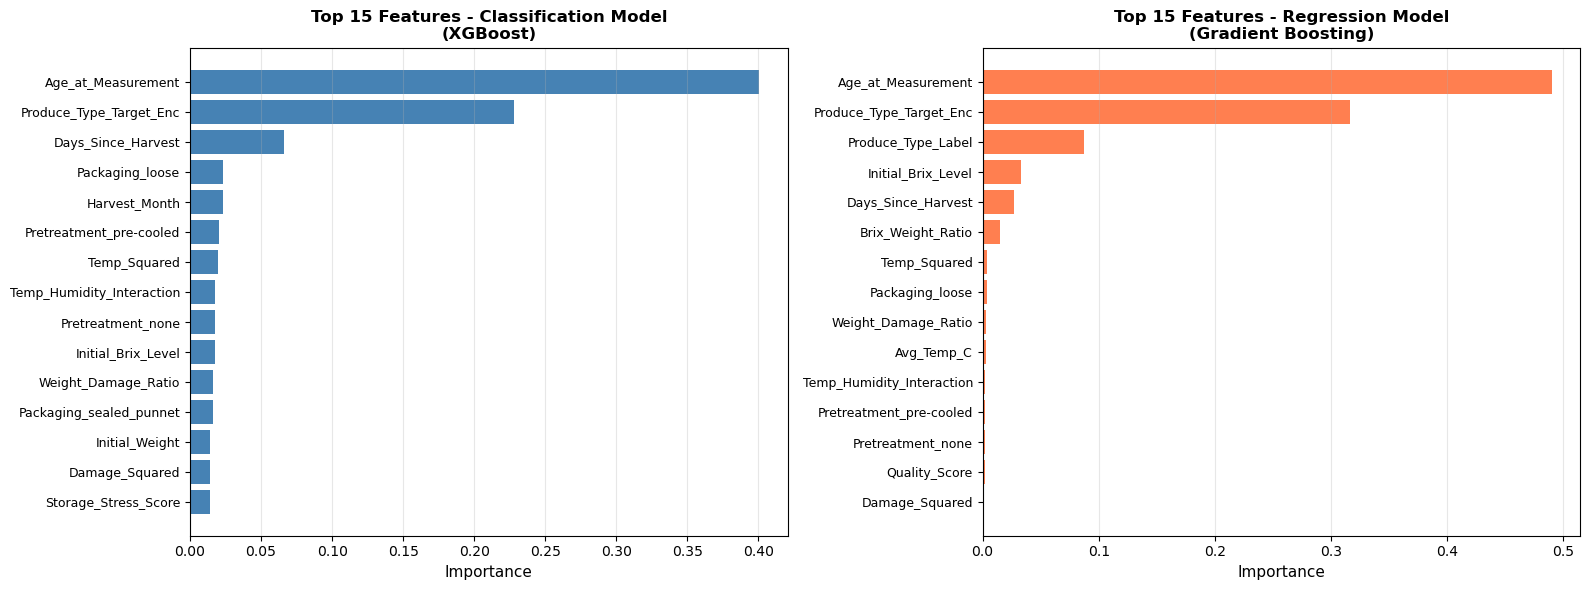


✓ Feature importance comparison saved as 'feature_importance_both_models.png'

Top 10 Features for Classification:
                  feature  importance
       Age_at_Measurement    0.400519
  Produce_Type_Target_Enc    0.227964
       Days_Since_Harvest    0.066374
          Packaging_loose    0.023436
            Harvest_Month    0.022994
  Pretreatment_pre-cooled    0.020542
             Temp_Squared    0.019447
Temp_Humidity_Interaction    0.017568
        Pretreatment_none    0.017555
       Initial_Brix_Level    0.017186

Top 10 Features for Regression:
                feature  importance
     Age_at_Measurement    0.489967
Produce_Type_Target_Enc    0.316768
     Produce_Type_Label    0.087407
     Initial_Brix_Level    0.032845
     Days_Since_Harvest    0.027338
      Brix_Weight_Ratio    0.015287
           Temp_Squared    0.004083
        Packaging_loose    0.003869
    Weight_Damage_Ratio    0.003112
             Avg_Temp_C    0.002842


In [ ]:
print("STEP 16: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importance from both models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Classification feature importance
if hasattr(best_classifier, 'feature_importances_'):
    clf_importance = pd.DataFrame({
        'feature': X_train_selected.columns,
        'importance': best_classifier.feature_importances_
    }).sort_values('importance', ascending=False).head(15)

    axes[0].barh(range(len(clf_importance)), clf_importance['importance'], color='steelblue')
    axes[0].set_yticks(range(len(clf_importance)))
    axes[0].set_yticklabels(clf_importance['feature'], fontsize=9)
    axes[0].set_xlabel('Importance', fontsize=11)
    axes[0].set_title(f'Top 15 Features - Classification Model\n({best_clf_name})',
                     fontsize=12, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3, axis='x')

# Regression feature importance
if hasattr(best_regressor, 'feature_importances_'):
    reg_importance = pd.DataFrame({
        'feature': X_train_selected.columns,
        'importance': best_regressor.feature_importances_
    }).sort_values('importance', ascending=False).head(15)

    axes[1].barh(range(len(reg_importance)), reg_importance['importance'], color='coral')
    axes[1].set_yticks(range(len(reg_importance)))
    axes[1].set_yticklabels(reg_importance['feature'], fontsize=9)
    axes[1].set_xlabel('Importance', fontsize=11)
    axes[1].set_title(f'Top 15 Features - Regression Model\n({best_reg_name})',
                     fontsize=12, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance_both_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance comparison saved as 'feature_importance_both_models.png'")

# Print top features
print("\nTop 10 Features for Classification:")
if hasattr(best_classifier, 'feature_importances_'):
    print(clf_importance.head(10).to_string(index=False))

print("\nTop 10 Features for Regression:")
if hasattr(best_regressor, 'feature_importances_'):
    print(reg_importance.head(10).to_string(index=False))


> As we can see for both classification and regerssion "Age_at_Measurement" and "Produce_Type_Target_Enc" came out on top 

>3rd best feature for classification came out to be "Days_Since_Harvest" & for regression came out to be "Produce_Type_Label"  

STEP 17: DETAILED ERROR ANALYSIS

Worst 10 Predictions:
         Actual  Predicted     Error  Abs_Error Actual_Class Predicted_Class
1571   5.574239  11.984883 -6.410644   6.410644  Not Expired         Expired
3460  13.697071  19.375104 -5.678032   5.678032  Not Expired         Expired
1993  14.907649   9.648514  5.259135   5.259135  Not Expired         Expired
3185  14.403979  19.514293 -5.110315   5.110315  Not Expired         Expired
398   25.889215  20.893687  4.995528   4.995528  Not Expired         Expired
2916  34.023072  29.140803  4.882270   4.882270  Not Expired         Expired
2307  38.604528  43.226700 -4.622172   4.622172  Not Expired         Expired
1877   1.932211   6.548386 -4.616175   4.616175  Not Expired         Expired
3095  17.646170  13.206045  4.440125   4.440125  Not Expired         Expired
3448   0.279583   4.491854 -4.212271   4.212271  Not Expired         Expired

Error Statistics:
  Mean Error: -0.02 days
  Std Error: 1.17 days
  Mean Absolute Error: 0.53 da

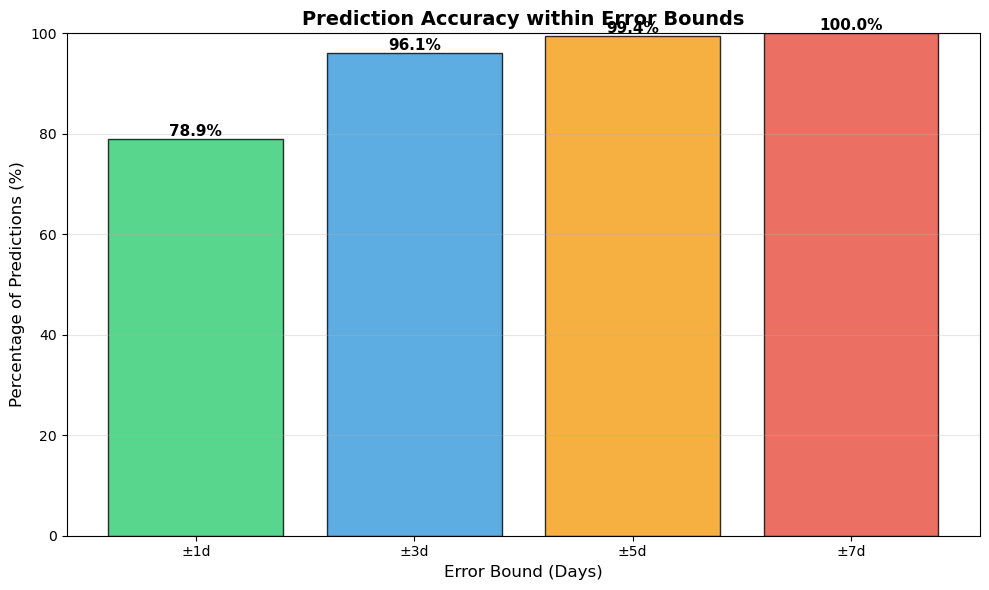


✓ Error analysis visualization saved as 'prediction_accuracy_bounds.png'


In [29]:
print("STEP 17: DETAILED ERROR ANALYSIS")
print("="*80)

# Create error analysis dataframe
error_analysis = pd.DataFrame({
    'Actual': y_test_reg.values,
    'Predicted': final_predictions,
    'Error': residuals,
    'Abs_Error': abs_errors,
    'Actual_Class': ['Expired' if x == 0 else 'Not Expired' for x in y_test_reg],
    'Predicted_Class': ['Expired' if x == 0 else 'Not Expired' for x in y_pred_class_best]
})

# Identify worst predictions
worst_predictions = error_analysis.nlargest(10, 'Abs_Error')
print("\nWorst 10 Predictions:")
print(worst_predictions)

# Error statistics
print("\nError Statistics:")
print(f"  Mean Error: {residuals.mean():.2f} days")
print(f"  Std Error: {residuals.std():.2f} days")
print(f"  Mean Absolute Error: {abs_errors.mean():.2f} days")
print(f"  Median Absolute Error: {np.median(abs_errors):.2f} days")
print(f"  Max Absolute Error: {abs_errors.max():.2f} days")

# Percentage of predictions within certain error bounds
within_1_day = (abs_errors <= 1).sum() / len(abs_errors) * 100
within_3_days = (abs_errors <= 3).sum() / len(abs_errors) * 100
within_5_days = (abs_errors <= 5).sum() / len(abs_errors) * 100
within_7_days = (abs_errors <= 7).sum() / len(abs_errors) * 100

print(f"\nPrediction Accuracy within Error Bounds:")
print(f"  Within ±1 day: {within_1_day:.2f}%")
print(f"  Within ±3 days: {within_3_days:.2f}%")
print(f"  Within ±5 days: {within_5_days:.2f}%")
print(f"  Within ±7 days: {within_7_days:.2f}%")

# Visualize error bounds
fig, ax = plt.subplots(figsize=(10, 6))
bounds = [1, 3, 5, 7]
percentages = [within_1_day, within_3_days, within_5_days, within_7_days]
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']

bars = ax.bar([f'±{b}d' for b in bounds], percentages, color=colors, edgecolor='black', alpha=0.8)
ax.set_ylabel('Percentage of Predictions (%)', fontsize=12)
ax.set_xlabel('Error Bound (Days)', fontsize=12)
ax.set_title('Prediction Accuracy within Error Bounds', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('prediction_accuracy_bounds.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Error analysis visualization saved as 'prediction_accuracy_bounds.png'")

> Prediction with less than a day gap came out to be 78.9% and 96.1% for the 3 day gap

>Every prediction was under 7 days error which is a good model

In [30]:
import joblib
print("STEP 18: SAVING MODELS AND ARTIFACTS")
print("="*80)

# Save models
joblib.dump(best_classifier, f'classifier_{best_clf_name.replace(" ", "_").lower()}.pkl')
joblib.dump(best_regressor, f'regressor_{best_reg_name.replace(" ", "_").lower()}.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features, 'selected_features.pkl')
joblib.dump(le_produce, 'label_encoder_produce.pkl')

print(f"\n✓ Classifier saved: classifier_{best_clf_name.replace(' ', '_').lower()}.pkl")
print(f"✓ Regressor saved: regressor_{best_reg_name.replace(' ', '_').lower()}.pkl")
print("✓ Scaler saved: scaler.pkl")
print("✓ Selected features saved: selected_features.pkl")
print("✓ Label encoder saved: label_encoder_produce.pkl")

# Save comprehensive results
results_summary = {
    'classification_model': best_clf_name,
    'regression_model': best_reg_name,
    'classification_metrics': {
        'accuracy': classification_results[best_clf_name]['test_accuracy'],
        'roc_auc': classification_results[best_clf_name]['roc_auc']
    },
    'regression_metrics': {
        'mae': regression_results[best_reg_name]['test_mae'],
        'rmse': regression_results[best_reg_name]['test_rmse'],
        'r2': regression_results[best_reg_name]['test_r2']
    },
    'combined_metrics': {
        'overall_mae': overall_mae,
        'overall_rmse': overall_rmse,
        'overall_r2': overall_r2,
        'within_1_day': within_1_day,
        'within_3_days': within_3_days,
        'within_5_days': within_5_days,
        'within_7_days': within_7_days
    },
    'feature_count': len(selected_features),
    'train_size': len(X_train),
    'test_size': len(X_test),
    'zero_percentage': zero_percentage
}

import json
with open('model_results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print("✓ Results summary saved: model_results_summary.json")

STEP 18: SAVING MODELS AND ARTIFACTS

✓ Classifier saved: classifier_xgboost.pkl
✓ Regressor saved: regressor_gradient_boosting.pkl
✓ Scaler saved: scaler.pkl
✓ Selected features saved: selected_features.pkl
✓ Label encoder saved: label_encoder_produce.pkl
✓ Results summary saved: model_results_summary.json


In [ ]:
print("STEP 19: PREDICTION PIPELINE CREATION")
print("="*80)

def predict_shelf_life(new_data, classifier, regressor, scaler, features):
    """
    Predict shelf life for new data using two-stage approach

    Parameters:
    -----------
    new_data : DataFrame
        New data with same features as training data (before encoding/scaling)
    classifier : trained classifier model
    regressor : trained regressor model
    scaler : fitted StandardScaler
    features : list of selected feature names

    Returns:
    --------
    predictions : array of predicted shelf life days
    """
    # Preprocess new data (same steps as training)
    # NOTE: In production, you'd need to apply all preprocessing steps

    # Scale features
    new_data_scaled = scaler.transform(new_data[features])
    # Stage 1: Classify
    is_expired = classifier.predict(new_data_scaled)

    # Stage 2: Regress for non-expired
    predictions = np.zeros(len(new_data))
    not_expired_mask = is_expired == 0

    if not_expired_mask.sum() > 0:
        predictions[not_expired_mask] = regressor.predict(new_data_scaled[not_expired_mask])
        predictions = np.maximum(predictions, 0)  # Ensure non-negative

    return predictions, is_expired

print("\n✓ Prediction function 'predict_shelf_life()' created")
print("\nUsage example:")
print("  predictions, is_expired = predict_shelf_life(new_data, best_classifier, best_regressor, scaler, selected_features)")

STEP 19: PREDICTION PIPELINE CREATION

✓ Prediction function 'predict_shelf_life()' created

Usage example:
  predictions, is_expired = predict_shelf_life(new_data, best_classifier, best_regressor, scaler, selected_features)


In [ ]:
# STEP 20: FINAL SUMMARY REPORT
#==============================================================================

print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    SHELF LIFE PREDICTION PROJECT COMPLETE                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 DATASET SUMMARY
  • Original samples: {len(df_encoded)} rows
  • Features used: {len(selected_features)} (from {len(X.columns)} engineered)
  • Train/Test split: {len(X_train)}/{len(X_test)} (80/20)
  • Zero values: {zero_count} ({zero_percentage:.2f}%)

🎯 MODEL PERFORMANCE

  Two-Stage Approach:
  ┌─────────────────────────────────────────────────────────────┐
  │ Stage 1: Binary Classification ({best_clf_name})
  │   • Accuracy: {classification_results[best_clf_name]['test_accuracy']:.4f}
  │   • ROC-AUC: {classification_results[best_clf_name]['roc_auc']:.4f}
  └─────────────────────────────────────────────────────────────┘

  ┌─────────────────────────────────────────────────────────────┐
  │ Stage 2: Regression ({best_reg_name})
  │   • MAE: {regression_results[best_reg_name]['test_mae']:.2f} days
  │   • RMSE: {regression_results[best_reg_name]['test_rmse']:.2f} days
  │   • R²: {regression_results[best_reg_name]['test_r2']:.4f}
  └─────────────────────────────────────────────────────────────┘

  ┌─────────────────────────────────────────────────────────────┐
  │ Combined Model Performance
  │   • Overall MAE: {overall_mae:.2f} days
  │   • Overall RMSE: {overall_rmse:.2f} days
  │   • Overall R²: {overall_r2:.4f}
  └─────────────────────────────────────────────────────────────┘

📈 PREDICTION ACCURACY
  • Within ±1 day: {within_1_day:.1f}%
  • Within ±3 days: {within_3_days:.1f}%
  • Within ±5 days: {within_5_days:.1f}%
  • Within ±7 days: {within_7_days:.1f}%

💾 SAVED ARTIFACTS
  ✓ classifier_{best_clf_name.replace(' ', '_').lower()}.pkl
  ✓ regressor_{best_reg_name.replace(' ', '_').lower()}.pkl
  ✓ scaler.pkl
  ✓ selected_features.pkl
  ✓ label_encoder_produce.pkl
  ✓ model_results_summary.json

📁 GENERATED VISUALIZATIONS
  ✓ target_analysis.png
  ✓ outlier_detection.png
  ✓ feature_importance.png
  ✓ model_performance_complete.png
  ✓ feature_importance_both_models.png
  ✓ prediction_accuracy_bounds.png

🚀 NEXT STEPS
  1. Review feature importance to understand key drivers
  2. Analyze worst predictions for improvement opportunities
  3. Consider hyperparameter tuning for better performance
  4. Deploy model using the predict_shelf_life() function
  5. Monitor model performance on new data
  6. Retrain periodically with fresh data

═══════════════════════════════════════════════════════════════════════════════
                           PROJECT COMPLETED SUCCESSFULLY!
═══════════════════════════════════════════════════════════════════════════════
""")

print("\n" + "="*80)
print("All steps completed! Check the output files and visualizations.")
print("="*80)
print("Thank You")


FINAL SUMMARY REPORT

╔══════════════════════════════════════════════════════════════════════════════╗
║                    SHELF LIFE PREDICTION PROJECT COMPLETE                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 DATASET SUMMARY
  • Original samples: 3552 rows
  • Features used: 29 (from 29 engineered)
  • Train/Test split: 2841/711 (80/20)
  • Zero values: 2448 (68.92%)

🎯 MODEL PERFORMANCE

  Two-Stage Approach:
  ┌─────────────────────────────────────────────────────────────┐
  │ Stage 1: Binary Classification (XGBoost)
  │   • Accuracy: 0.9831
  │   • ROC-AUC: 0.9982
  └─────────────────────────────────────────────────────────────┘
  
  ┌─────────────────────────────────────────────────────────────┐
  │ Stage 2: Regression (Gradient Boosting)
  │   • MAE: 1.69 days
  │   • RMSE: 2.08 days
  │   • R²: 0.9721
  └─────────────────────────────────────────────────────────────┘
  
  ┌─────────────────────────────────────────────────